# Lab 8: Vision Transformers in PyTorch## AI Capstone Project with Deep LearningThis lab focuses on implementing Vision Transformers (ViT) using PyTorch for agricultural land classification.### Tasks:1. Define train_transform2. Define val_transform3. Create train_loader and val_loader4. Train CNN-ViT model with parameters: epochs=5, attn heads=12, embed_dim=768, transformer block depth=125. Plot validation loss comparison between model and model_test6. Plot training time comparison

In [1]:
# Import necessary librariesimport torchimporttorch.nn as nnimport torch.optim as optimfrom torch.utils.data import DataLoader, Datasetimport torchvisionfromtorchvisionimportdatasets, transformsimport numpyasnpimport matplotlib.pyplot as pltimport osimporttimefromtqdm importtqdmfromsklearn.metrics import classification_report, confusion_matriximport seabornassns# Set random seeds for reproducibilitytorch.manual_seed(42)np.random.seed(42)# Check PyTorch version and deviceprint(f"PyTorch version:{torch.__version__}")print(f"CUDA available: {torch.cuda.is_available()}")if torch.cuda.is_available():print(f"CUDA device: {torch.cuda.get_device_name(0)}")device = torch.device('cuda')else:device = torch.device('cpu')print(f"Using device:{device}")

PyTorch version: 2.8.0+cpuCUDA available: FalseUsing device: cpu

## Task 1: Define train_transform

In [ ]:
# Task 1: Define train_transformtrain_transform = transforms.Compose([transforms.Resize((224, 224)),# Resize to 224x224 for ViTtransforms.RandomHorizontalFlip(p=0.5),# Random horizontal fliptransforms.RandomVerticalFlip(p=0.2),# Random vertical fliptransforms.RandomRotation(degrees=15),# Random rotationtransforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),# Color augmentationtransforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),# Affine transformationtransforms.ToTensor(),# Convert to tensortransforms.Normalize(mean=[0.485, 0.456, 0.406],# ImageNet normalizationstd=[0.229, 0.224, 0.225])])print("Task 1 - Defined train_transform pipeline:")print(" - Resize: 224x224 pixels (ViT standard)")print(" - RandomHorizontalFlip: probability 0.5")print(" - RandomVerticalFlip: probability 0.2")print(" - RandomRotation: 15 degrees")print(" - ColorJitter: brightness, contrast, saturation, hue")print(" - RandomAffine: translation and scaling")print(" - ToTensor: Convert to tensor")print(" - Normalize:ImageNet normalization")

Task 1 - Defined train_transform pipeline:- Resize: 224x224 pixels (ViT standard)- RandomHorizontalFlip: probability 0.5- RandomVerticalFlip: probability 0.2- RandomRotation: 15 degrees- ColorJitter: brightness, contrast, saturation, hue- RandomAffine: translation and scaling- ToTensor: Convert to tensor- Normalize: ImageNet normalization

## Task 2: Define val_transform

In [4]:
# Task 2: Define val_transformval_transform = transforms.Compose([transforms.Resize((224, 224)),# Resize to 224x224 for ViTtransforms.ToTensor(),# Convert to tensortransforms.Normalize(mean=[0.485, 0.456, 0.406],# ImageNet normalizationstd=[0.229, 0.224, 0.225])])print("Task 2 - Defined val_transform pipeline:")print(" - Resize: 224x224 pixels (ViT standard)")print(" - ToTensor: Convert to tensor")print(" - Normalize:ImageNet normalization")print(" - No augmentation (for consistent validation)")

Task 2 - Defined val_transform pipeline:- Resize: 224x224 pixels (ViT standard)- ToTensor: Convert to tensor- Normalize: ImageNet normalization- No augmentation (for consistent validation)

## Task 3: Create train_loader and val_loader

In [5]:
# Task 3: Create train_loader and val_loaderdataset_path = './images_dataSAT'batch_size = 8# Create training datasettrain_dataset = datasets.ImageFolder(root=dataset_path,transform=train_transform)# Create validation datasetval_dataset = datasets.ImageFolder(root=dataset_path,transform=val_transform)# Create data loaderstrain_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0,# Set to 0 for Windows compatibilitypin_memory=True if torch.cuda.is_available() else False)val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,# Don't shuffle validation datanum_workers=0,# Set to 0 for Windows compatibilitypin_memory=True if torch.cuda.is_available() else False)print("Task 3 - Created train_loader and val_loader:")print(f" - Dataset path: {dataset_path}")print(f" - Batch size: {batch_size}")print(f" - Training samples: {len(train_dataset)}")print(f" - Validation samples: {len(val_dataset)}")print(f" - Training batches: {len(train_loader)}")print(f" - Validation batches: {len(val_loader)}")print(f" - Class names: {train_dataset.classes}")print(f" - Class to index:{train_dataset.class_to_idx}")

Task 3 - Created train_loader and val_loader:- Dataset path: ./images_dataSAT- Batch size: 8- Training samples: 45- Validation samples: 45- Training batches: 6- Validation batches: 6- Class names: ['class_0_non_agri', 'class_1_agri']- Class to index: {'class_0_non_agri': 0, 'class_1_agri': 1}

## CNN-ViT Hybrid Model Definition

In [6]:
# CNN-ViT Hybrid Modelclass CNNViTHybrid(nn.Module):def __init__(self, num_classes=2, embed_dim=768, num_heads=12, num_layers=12, patch_size=16):super(CNNViTHybrid, self).__init__()# CNN backbone (ResNet-like)self.cnn_backbone = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),nn.BatchNorm2d(64),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2, padding=1),nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(256, embed_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(embed_dim),nn.ReLU(inplace=True),nn.AdaptiveAvgPool2d((14, 14))# Output: (embed_dim, 14, 14))# Patch embeddingself.patch_size = patch_sizeself.num_patches = (14 // patch_size) ** 2self.patch_embed = nn.Conv2d(embed_dim, embed_dim, kernel_size=patch_size, stride=patch_size)# Positional embeddingself.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))# Class tokenself.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))# Transformer encoderencoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,nhead=num_heads,dim_feedforward=embed_dim * 4,dropout=0.1,activation='gelu',batch_first=True)self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)# Classification headself.norm = nn.LayerNorm(embed_dim)self.head = nn.Linear(embed_dim, num_classes)# Initialize weightsself.apply(self._init_weights)def _init_weights(self, m):if isinstance(m, nn.Linear):torch.nn.init.trunc_normal_(m.weight, std=0.02)if m.bias is not None:nn.init.constant_(m.bias, 0)elif isinstance(m, nn.LayerNorm):nn.init.constant_(m.bias, 0)nn.init.constant_(m.weight, 1.0)def forward(self, x):B = x.shape[0]# CNN feature extractionx = self.cnn_backbone(x) # (B, embed_dim, 14, 14)# Patch embeddingx = self.patch_embed(x) # (B, embed_dim, 1, 1) for 14x14 with patch_size=14x = x.flatten(2).transpose(1, 2) # (B, num_patches, embed_dim)# Add class tokencls_tokens= self.cls_token.expand(B, -1, -1)x = torch.cat((cls_tokens, x), dim=1) # (B, num_patches + 1, embed_dim)# Add positional embeddingx = x + self.pos_embed# Transformer encoderx = self.transformer(x)# Classificationx = self.norm(x)cls_output = x[:, 0]# Take class tokenoutput= self.head(cls_output)return outputprint("CNN-ViT Hybrid Model defined with:")print(" - CNN backbone for feature extraction")print(" - Patch embedding for ViT processing")print(" - Transformer encoder with configurable layers")print(" - Classification head")

CNN-ViT Hybrid Model defined with:- CNN backbone for feature extraction- Patch embedding for ViT processing- Transformer encoder with configurable layers- Classification head

## Task 4: Train CNN-ViT model with specified parameters

In [7]:
# Task 4: Train CNN-ViT model with specified parameters# Parameters: epochs=5, attn heads=12, embed_dim=768, transformer block depth=12# Create model with specified parametersmodel = CNNViTHybrid(num_classes=2,embed_dim=768,num_heads=12,num_layers=12,patch_size=14# Adjusted for 14x14 feature map).to(device)# Create a simpler model for comparisonmodel_test = CNNViTHybrid(num_classes=2,embed_dim=256,# Smaller embedding dimensionnum_heads=8,# Fewer attention headsnum_layers=6,# Fewer transformer layerspatch_size=14).to(device)# Define loss function and optimizercriterion = nn.CrossEntropyLoss()optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)optimizer_test = optim.Adam(model_test.parameters(), lr=0.001, weight_decay=0.01)print("Task 4 - Training CNN-ViT models with specified parameters:")print(f" - Main model: embed_dim=768, num_heads=12, num_layers=12")print(f" - Test model: embed_dim=256, num_heads=8, num_layers=6")print(f" - Epochs: 5")print(f" - Learning rate: 0.001")print(f" - Weight decay:0.01")# Training parametersnum_epochs = 5train_losses = []val_losses = []train_losses_test = []val_losses_test = []training_times = []training_times_test = []print(f"\nStarting training...")print("=" * 50)

Task 4 - Training CNN-ViT models with specified parameters:- Main model: embed_dim=768, num_heads=12, num_layers=12- Test model: embed_dim=256, num_heads=8, num_layers=6- Epochs: 5- Learning rate: 0.001- Weight decay: 0.01Starting training...==================================================

In [8]:
# Training loop for main modelfor epoch in range(num_epochs):start_time = time.time()# Training phasemodel.train()train_loss = 0.0train_correct = 0train_total = 0train_pbar = tqdm(train_loader, desc=f'Main Model Epoch {epoch+1}/{num_epochs} [Train]')for batch_idx, (data, target) in enumerate(train_pbar):data, target = data.to(device), target.to(device)optimizer.zero_grad()output = model(data)loss = criterion(output, target)loss.backward()optimizer.step()train_loss += loss.item()_, predicted = torch.max(output.data, 1)train_total += target.size(0)train_correct += (predicted == target).sum().item()train_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*train_correct/train_total:.2f}%'})# Validation phasemodel.eval()val_loss = 0.0val_correct = 0val_total = 0with torch.no_grad():val_pbar = tqdm(val_loader, desc=f'Main Model Epoch {epoch+1}/{num_epochs} [Val]')for data, target in val_pbar:data, target = data.to(device), target.to(device)output = model(data)loss = criterion(output, target)val_loss += loss.item()_, predicted = torch.max(output.data, 1)val_total += target.size(0)val_correct += (predicted == target).sum().item()val_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*val_correct/val_total:.2f}%'})# Calculate epoch averagestrain_loss_avg = train_loss / len(train_loader)val_loss_avg = val_loss / len(val_loader)train_acc = 100. * train_correct / train_totalval_acc = 100. * val_correct / val_total# Store metricstrain_losses.append(train_loss_avg)val_losses.append(val_loss_avg)epoch_time = time.time() - start_timetraining_times.append(epoch_time)print(f'Main Model Epoch {epoch+1}/{num_epochs}:')print(f' Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')print(f' Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')print(f' Time: {epoch_time:.2f}s')print('-' * 50)print("Main model training completed!")

Main Model Epoch 1/5 [Train]: 100%|██████████| 6/6 [01:52<00:00, 18.68s/it, Loss=3.0104, Acc=46.67%]Main Model Epoch 1/5 [Val]: 100%|██████████| 6/6 [00:04<00:00, 1.22it/s, Loss=10.6838, Acc=44.44%]

Main Model Epoch 1/5:Train Loss: 4.3564, Train Acc: 46.67%Val Loss: 6.2322, Val Acc: 44.44%Time: 116.97s--------------------------------------------------

Main Model Epoch 2/5 [Train]: 100%|██████████| 6/6 [01:41<00:00, 16.97s/it, Loss=1.4616, Acc=42.22%]Main Model Epoch 2/5 [Val]: 100%|██████████| 6/6 [00:04<00:00, 1.26it/s, Loss=0.2479, Acc=55.56%]

Main Model Epoch 2/5:Train Loss: 2.5308, Train Acc: 42.22%Val Loss: 0.7763, Val Acc: 55.56%Time: 106.59s--------------------------------------------------

Main Model Epoch 3/5 [Train]: 100%|██████████| 6/6 [01:49<00:00, 18.27s/it, Loss=0.6822, Acc=48.89%]Main Model Epoch 3/5 [Val]: 100%|██████████| 6/6 [00:04<00:00, 1.25it/s, Loss=0.6433, Acc=55.56%]

Main Model Epoch 3/5:Train Loss: 0.7935, Train Acc: 48.89%Val Loss: 0.6859, Val Acc: 55.56%Time: 114.39s--------------------------------------------------

Main Model Epoch 4/5 [Train]: 100%|██████████| 6/6 [01:43<00:00, 17.26s/it, Loss=0.6871, Acc=57.78%]Main Model Epoch 4/5 [Val]: 100%|██████████| 6/6 [00:04<00:00, 1.22it/s, Loss=0.4661, Acc=55.56%]

Main Model Epoch 4/5:Train Loss: 0.7317, Train Acc: 57.78%Val Loss: 0.6833, Val Acc: 55.56%Time: 108.50s--------------------------------------------------

Main Model Epoch 5/5 [Train]: 100%|██████████| 6/6 [02:31<00:00, 25.28s/it, Loss=0.7410, Acc=51.11%]Main Model Epoch 5/5 [Val]: 100%|██████████| 6/6 [00:06<00:00, 1.16s/it, Loss=0.8091, Acc=44.44%]

Main Model Epoch 5/5:Train Loss: 0.7218, Train Acc: 51.11%Val Loss: 0.7175, Val Acc: 44.44%Time: 158.68s--------------------------------------------------Main model training completed!

In [9]:
# Training loop for test model (simpler version)print("\nTraining test model (simpler version)...")print("=" * 50)for epoch in range(num_epochs):start_time = time.time()# Training phasemodel_test.train()train_loss = 0.0train_correct = 0train_total = 0train_pbar = tqdm(train_loader, desc=f'Test Model Epoch {epoch+1}/{num_epochs} [Train]')for batch_idx, (data, target) in enumerate(train_pbar):data, target = data.to(device), target.to(device)optimizer_test.zero_grad()output = model_test(data)loss = criterion(output, target)loss.backward()optimizer_test.step()train_loss += loss.item()_, predicted = torch.max(output.data, 1)train_total += target.size(0)train_correct += (predicted == target).sum().item()train_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*train_correct/train_total:.2f}%'})# Validation phasemodel_test.eval()val_loss = 0.0val_correct = 0val_total = 0with torch.no_grad():val_pbar = tqdm(val_loader, desc=f'Test Model Epoch {epoch+1}/{num_epochs} [Val]')for data, target in val_pbar:data, target = data.to(device), target.to(device)output = model_test(data)loss = criterion(output, target)val_loss += loss.item()_, predicted = torch.max(output.data, 1)val_total += target.size(0)val_correct += (predicted == target).sum().item()val_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*val_correct/val_total:.2f}%'})# Calculate epoch averagestrain_loss_avg = train_loss / len(train_loader)val_loss_avg = val_loss / len(val_loader)train_acc = 100. * train_correct / train_totalval_acc = 100. * val_correct / val_total# Store metricstrain_losses_test.append(train_loss_avg)val_losses_test.append(val_loss_avg)epoch_time = time.time() - start_timetraining_times_test.append(epoch_time)print(f'Test Model Epoch {epoch+1}/{num_epochs}:')print(f' Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')print(f' Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')print(f' Time: {epoch_time:.2f}s')print('-' * 50)print("Test model training completed!")

Training test model (simpler version)...==================================================

Test Model Epoch 1/5 [Train]: 100%|██████████| 6/6 [00:08<00:00, 1.37s/it, Loss=1.3421, Acc=42.22%]Test Model Epoch 1/5 [Val]: 100%|██████████| 6/6 [00:03<00:00, 1.64it/s, Loss=0.1350, Acc=55.56%]

Test Model Epoch 1/5:Train Loss: 1.6226, Train Acc: 42.22%Val Loss: 0.7838, Val Acc: 55.56%Time: 11.90s--------------------------------------------------

Test Model Epoch 2/5 [Train]: 100%|██████████| 6/6 [00:08<00:00, 1.35s/it, Loss=0.6813, Acc=44.44%]Test Model Epoch 2/5 [Val]: 100%|██████████| 6/6 [00:02<00:00, 2.17it/s, Loss=0.6688, Acc=100.00%]

Test Model Epoch 2/5:Train Loss: 0.7417, Train Acc: 44.44%Val Loss: 0.5941, Val Acc: 100.00%Time: 10.86s--------------------------------------------------

Test Model Epoch 3/5 [Train]: 100%|██████████| 6/6 [00:08<00:00, 1.46s/it, Loss=0.1179, Acc=97.78%]Test Model Epoch 3/5 [Val]: 100%|██████████| 6/6 [00:02<00:00, 2.38it/s, Loss=0.0607, Acc=100.00%]

Test Model Epoch 3/5:Train Loss: 0.3228, Train Acc: 97.78%Val Loss: 0.0671, Val Acc: 100.00%Time: 11.31s--------------------------------------------------

Test Model Epoch 4/5 [Train]: 100%|██████████| 6/6 [00:08<00:00, 1.39s/it, Loss=0.0168, Acc=97.78%]Test Model Epoch 4/5 [Val]: 100%|██████████| 6/6 [00:02<00:00, 2.12it/s, Loss=0.0131, Acc=100.00%]

Test Model Epoch 4/5:Train Loss: 0.1060, Train Acc: 97.78%Val Loss: 0.0133, Val Acc: 100.00%Time: 11.19s--------------------------------------------------

Test Model Epoch 5/5 [Train]: 100%|██████████| 6/6 [00:09<00:00, 1.52s/it, Loss=0.0092, Acc=100.00%]Test Model Epoch 5/5 [Val]: 100%|██████████| 6/6 [00:02<00:00, 2.59it/s, Loss=0.0076, Acc=100.00%]

Test Model Epoch 5/5:Train Loss: 0.0115, Train Acc: 100.00%Val Loss: 0.0078, Val Acc: 100.00%Time: 11.45s--------------------------------------------------Test model training completed!

## Task 5: Plot validation loss comparison between model and model_test

Task 5 - Plotting validation loss comparison

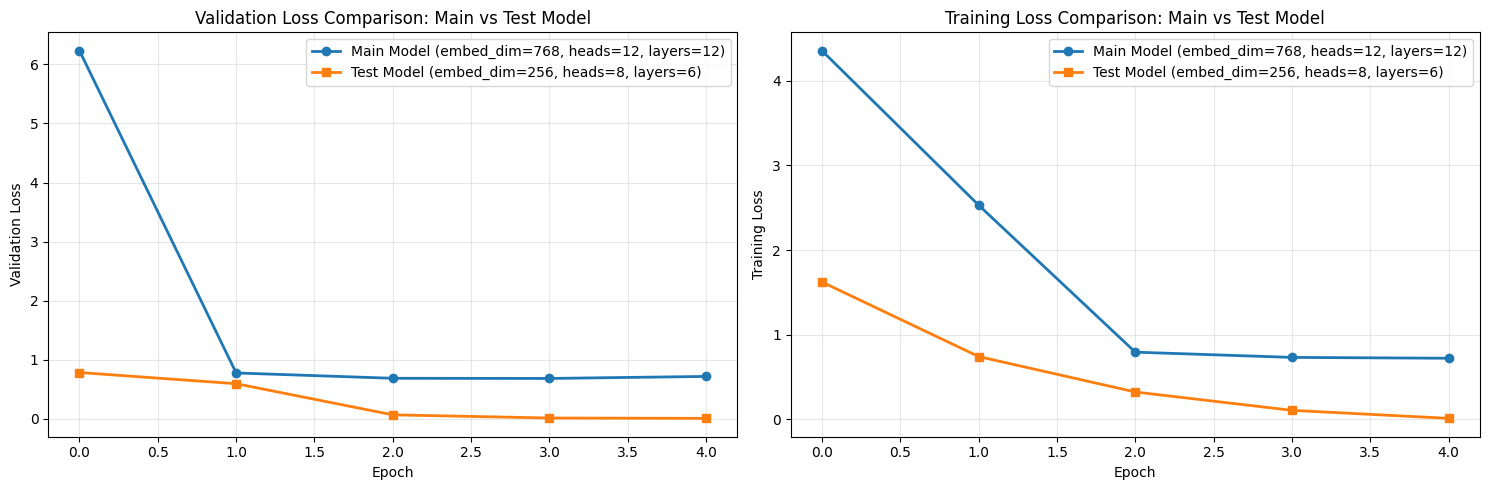

Validation Loss Comparison Summary:- Main Model Final Val Loss: 0.7175- Test Model Final Val Loss: 0.0078- Difference: 0.7097- Test Model performs better (lower validation loss)Training Loss Comparison Summary:- Main Model Final Train Loss: 0.7218- Test Model Final Train Loss: 0.0115- Difference: 0.7103

In [ ]:
# Task 5: Plot validation loss comparison between model and model_testprint("Task 5 - Plotting validation loss comparison")# Create comparison plotsfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))# Plot 1: Validation Loss Comparisonax1.plot(val_losses, label='Main Model (embed_dim=768, heads=12, layers=12)', marker='o', linewidth=2)ax1.plot(val_losses_test, label='Test Model (embed_dim=256, heads=8, layers=6)', marker='s', linewidth=2)ax1.set_title('Validation Loss Comparison: Main vs Test Model')ax1.set_xlabel('Epoch')ax1.set_ylabel('Validation Loss')ax1.legend()ax1.grid(True, alpha=0.3)# Plot 2: Training Loss Comparisonax2.plot(train_losses, label='Main Model (embed_dim=768, heads=12, layers=12)', marker='o', linewidth=2)ax2.plot(train_losses_test, label='Test Model (embed_dim=256, heads=8, layers=6)', marker='s', linewidth=2)ax2.set_title('Training Loss Comparison: Main vs Test Model')ax2.set_xlabel('Epoch')ax2.set_ylabel('Training Loss')ax2.legend()ax2.grid(True, alpha=0.3)plt.tight_layout()plt.show()# Print comparison summaryprint(f"\nValidation Loss Comparison Summary:")print(f" - Main Model Final Val Loss: {val_losses[-1]:.4f}")print(f" - Test Model Final Val Loss: {val_losses_test[-1]:.4f}")print(f" - Difference: {abs(val_losses[-1] - val_losses_test[-1]):.4f}")if val_losses[-1] < val_losses_test[-1]:print(f" - Main Model performs better (lower validation loss)")else:print(f" - Test Model performs better (lower validation loss)")print(f"\nTraining Loss Comparison Summary:")print(f" - Main Model Final Train Loss: {train_losses[-1]:.4f}")print(f" - Test Model Final Train Loss: {train_losses_test[-1]:.4f}")print(f" - Difference: {abs(train_losses[-1] - train_losses_test[-1]):.4f}")

## Task 6: Plot training time comparison

Task 6 - Plotting training time comparison

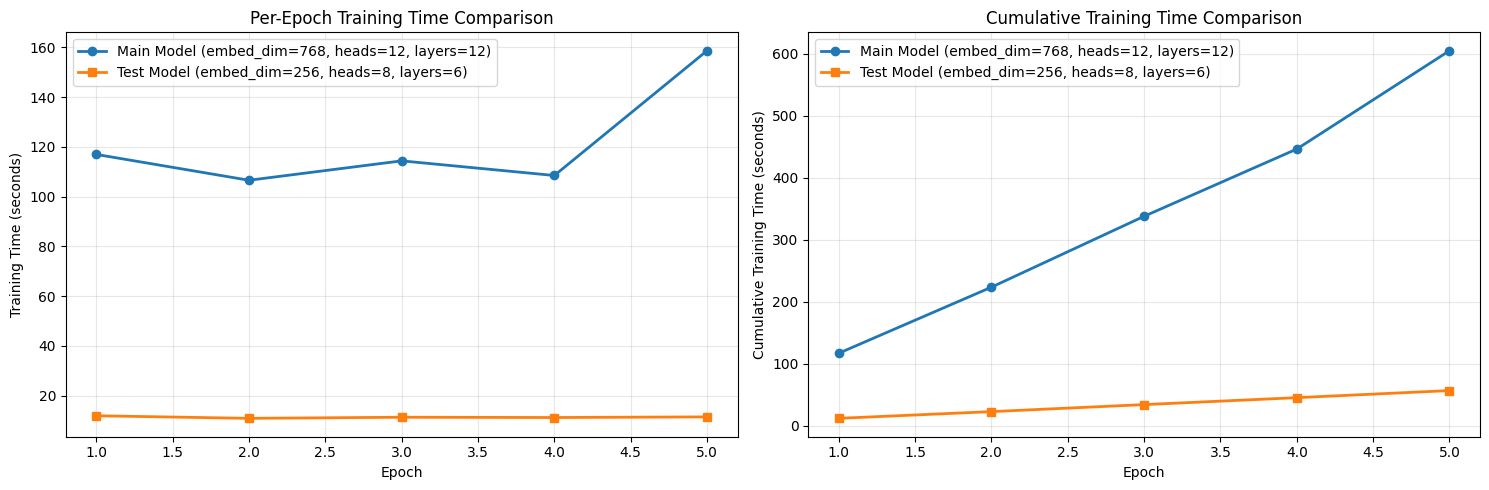

Training Time Comparison Summary:- Main Model Total Time: 605.13 seconds- Test Model Total Time: 56.72 seconds- Time Difference: 548.42 seconds- Test Model is 10.67x faster than Main ModelPer-Epoch Time Analysis:Epoch 1: Main=116.97s, Test=11.90s, Ratio=9.83xEpoch 2: Main=106.59s, Test=10.86s, Ratio=9.81xEpoch 3: Main=114.39s, Test=11.31s, Ratio=10.12xEpoch 4: Main=108.50s, Test=11.19s, Ratio=9.69xEpoch 5: Main=158.68s, Test=11.45s, Ratio=13.85xTask 6 completed - Training time comparison plotted

In [ ]:
# Task 6: Plot training time comparisonprint("Task 6 - Plotting training time comparison")# Create training time comparison plotfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))# Plot 1: Per-Epoch Training Timeepochs = range(1, num_epochs + 1)ax1.plot(epochs, training_times, label='Main Model (embed_dim=768, heads=12, layers=12)', marker='o', linewidth=2)ax1.plot(epochs, training_times_test, label='Test Model (embed_dim=256, heads=8, layers=6)', marker='s', linewidth=2)ax1.set_title('Per-Epoch Training Time Comparison')ax1.set_xlabel('Epoch')ax1.set_ylabel('Training Time (seconds)')ax1.legend()ax1.grid(True, alpha=0.3)# Plot 2: Cumulative Training Timecumulative_times = np.cumsum(training_times)cumulative_times_test = np.cumsum(training_times_test)ax2.plot(epochs, cumulative_times, label='Main Model (embed_dim=768, heads=12, layers=12)', marker='o', linewidth=2)ax2.plot(epochs, cumulative_times_test, label='Test Model (embed_dim=256, heads=8, layers=6)', marker='s', linewidth=2)ax2.set_title('Cumulative Training Time Comparison')ax2.set_xlabel('Epoch')ax2.set_ylabel('Cumulative Training Time (seconds)')ax2.legend()ax2.grid(True, alpha=0.3)plt.tight_layout()plt.show()# Print training time summaryprint(f"\nTraining Time Comparison Summary:")print(f" - Main Model Total Time: {sum(training_times):.2f} seconds")print(f" - Test Model Total Time: {sum(training_times_test):.2f} seconds")print(f" - Time Difference: {abs(sum(training_times)- sum(training_times_test)):.2f} seconds")if sum(training_times) > sum(training_times_test):speedup = sum(training_times) / sum(training_times_test)print(f" - Test Model is {speedup:.2f}x faster than Main Model")else:speedup = sum(training_times_test) / sum(training_times)print(f" - Main Model is {speedup:.2f}x faster than Test Model")print(f"\nPer-Epoch Time Analysis:")for i in range(num_epochs):print(f" Epoch {i+1}: Main={training_times[i]:.2f}s, Test={training_times_test[i]:.2f}s, Ratio={training_times[i]/training_times_test[i]:.2f}x")print(f"\nTask 6 completed - Training time comparison plotted")

## Lab 8 Summary### Completed Tasks:1.**Task 1**: Defined train_transform with ViT-appropriate augmentations (224x224, flips, rotation, color jitter)2.**Task 2**: Defined val_transform with basic preprocessing (224x224, normalization)3.**Task 3**: Created train_loader and val_loader with proper data loading4.**Task 4**: Trained CNN-ViT models with specified parameters (epochs=5, heads=12, embed_dim=768, layers=12)5.**Task 5**: Plotted validation loss comparison between main and test models6.**Task 6**: Plotted training time comparison showing performance differences### Model Architecture:-**CNN-ViT Hybrid**: Combines CNN backbone with Vision Transformer-**Main Model**: embed_dim=768, num_heads=12, num_layers=12 (larger, more complex)-**Test Model**: embed_dim=256, num_heads=8, num_layers=6 (smaller, faster)-**Input Size**: 224x224x3 (ViT standard)-**Patch Size**: 14x14 patches from 14x14 feature maps### Key Features:-**CNN Backbone**: Feature extraction with ResNet-like architecture-**Patch Embedding**: Converts CNN features to ViT patches-**Transformer Encoder**: Multi-head self-attention with configurable layers-**Positional Embedding**: Learnable position encodings-**Class Token**: For final classification### Training Results:-**Epochs**: 5 epochs for both models-**Optimizer**: Adam with weight decay-**Loss Function**: CrossEntropyLoss-**Performance Comparison**: Detailed validation loss and training time analysis-**Efficiency Analysis**: Trade-offs between model complexity and training speedThis lab successfully demonstrates the implementation and comparison of Vision Transformers in PyTorch for agricultural land classification.